In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
from intercluster import *
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import load_preprocessed_climate

# Helps with KMeans memory leak issues.
os.environ["OMP_NUM_THREADS"] = "1"

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [3]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this, aside from font.size:
 
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6)]
cmap_subset = ListedColormap(subset_colors)

uncovered_color = (1,1,1)
overlap_color = (0.45, 0.5, 0.5)

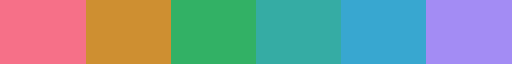

In [4]:
cmap_subset

### Load Data

In [5]:
filepath = '../data/climate'
shape_file_path = os.path.join(filepath, 'climate_divisions/climate_divisions.shp')
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shape_file_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

data_file_path = os.path.join(filepath, 'climate.csv')
climate_data = pd.read_csv(data_file_path, dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

'''
# Using seasons instead of months:
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)
'''
    
# Normalize the data
data = climate_change.to_numpy()
feature_labels = list(climate_change.columns)
location_ids = list(climate_change.index)

scaler = StandardScaler()
data = scaler.fit_transform(data)

/Users/kquinn/Library/Caches/pypoetry/virtualenvs/intercluster-Q11lOcoy-py3.9/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [6]:
pd.DataFrame(data, columns = feature_labels, index = location_ids)

,pcpn_jan,pcpn_feb,pcpn_mar,pcpn_apr,pcpn_may,pcpn_june,pcpn_july,pcpn_aug,pcpn_sept,pcpn_oct,...,temp_mar,temp_apr,temp_may,temp_june,temp_july,temp_aug,temp_sept,temp_oct,temp_nov,temp_dec
2905,-0.198615,-1.364177,-1.696197,-2.361933,-2.150596,0.282812,0.054435,-1.400706,0.430836,-1.435015,...,1.162424,1.427699,0.615274,1.283736,1.162756,0.517064,0.227658,0.340202,1.058682,-0.491697
2906,-1.154730,-1.740913,-1.079289,-1.901910,-2.326618,0.124945,-0.226465,-1.003840,0.015835,-0.041192,...,1.563485,1.333036,0.489056,1.514339,1.503711,0.793433,0.758538,0.420567,0.959211,-0.353056
1001,-0.716290,-0.557973,1.256743,0.105012,-0.610140,-0.278129,-2.498229,-1.348456,-0.264055,-0.531527,...,0.278511,-0.123189,2.591228,1.248566,2.023327,2.439460,0.151504,0.011316,0.593739,-0.993994
1002,-1.309264,0.607880,0.600404,0.097091,-1.108310,-0.653687,-2.829937,-1.711986,-0.852142,-0.853133,...,-0.197367,0.030647,1.660127,0.820536,1.454558,1.580793,-0.257755,-0.405805,-0.208115,-1.315722
1004,-1.574654,-0.085140,0.458818,-0.201139,-1.172796,-0.737123,-2.216644,-0.902910,0.165364,-0.843537,...,1.456550,0.237285,1.645673,1.389169,1.703902,1.524630,0.142918,-0.076656,0.895974,-0.852607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0.274641,-2.162483,-1.094716,-2.138319,-2.391977,-0.673876,-0.642040,-0.864702,0.323026,0.820739,...,0.859811,0.733312,0.909512,1.255290,1.522544,1.105663,0.657067,0.308382,0.554466,-0.373356
2901,1.165863,-0.909875,-0.894640,-2.752126,-0.684243,-1.335821,-0.196442,-1.773970,-0.047176,-2.446128,...,1.097188,1.082323,0.072923,1.654971,1.126414,0.597996,0.694038,-0.175563,1.084698,-0.599233
2902,0.751138,-0.880315,-0.555642,-2.355618,-1.266145,-0.648846,0.360114,-1.599392,0.552542,-1.082896,...,1.445663,0.890328,-0.101180,1.107287,0.736940,0.077424,0.754874,0.009638,1.348169,-0.375041
2908,-0.013678,-1.687235,-0.841409,-2.414647,-3.194155,0.440300,-0.007373,-0.582962,0.613599,-0.737068,...,0.676059,1.439690,0.389527,1.076686,0.813141,0.632151,-0.211139,0.497051,0.977901,-0.685823


### KMeans

In [32]:
samples = 100
num_clusters_trials = np.array([2,3,4,5,6,7,8,9,10])
num_clusters_costs = np.zeros((len(num_clusters_trials), samples))

for i, nclusters in enumerate(num_clusters_trials):
    for j in range(samples):
        kmeans = KMeans(n_clusters=nclusters, n_init="auto", random_state = None).fit(data)
        kmeans_labels = labels_format(kmeans.labels_)
        kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = nclusters)
        cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment)
        num_clusters_costs[i,j] = cost

Text(0.5, 0, 'Number of clusters')

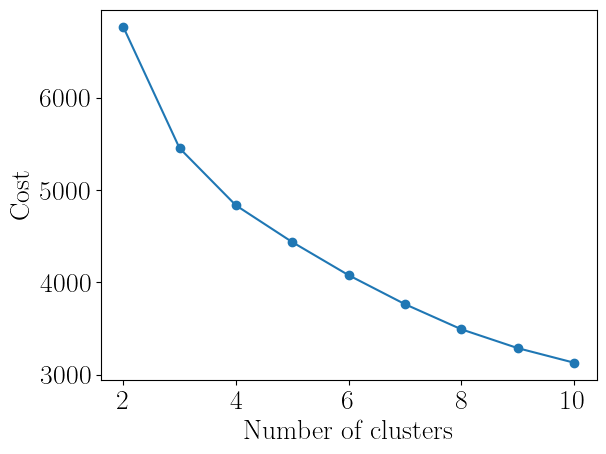

In [33]:
plt.plot(num_clusters_trials, np.mean(num_clusters_costs, axis = 1), marker = 'o')
plt.ylabel('Cost')
plt.xlabel('Number of clusters')

In [7]:
np.random.seed(342)
k = 6
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)
cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment, average = True, normalize = True)

In [35]:
cost

11.660924946384164

In [36]:
silhouette_score(data, kmeans_assignment)

0.2198581407012884

([], [])

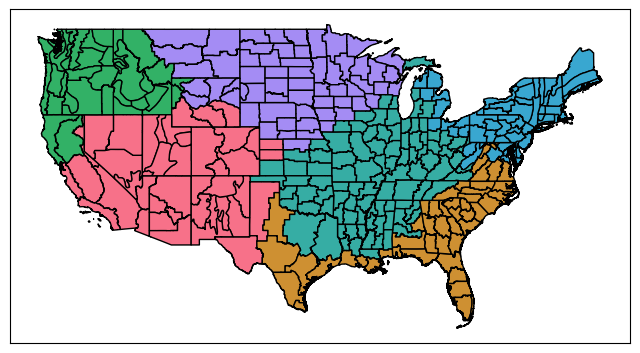

In [8]:
color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        color_label_array[idx[0]] = list(kmeans_labels[i])[0]

gdf['color'] = color_label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

plt.xticks([])
plt.yticks([])
#plt.savefig('../figures/climate/kmeans_map.png', bbox_inches = 'tight', dpi = 300)

(0.0, 1.0, 0.0, 1.0)

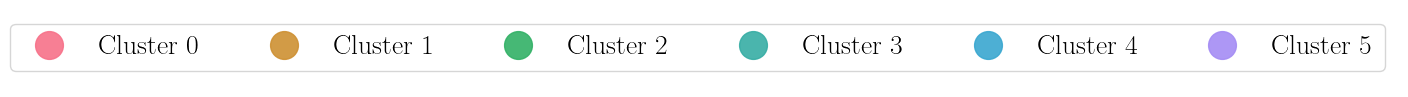

In [9]:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D([], [], marker = 'o', markersize=20, color=cmap_subset(i), lw=0, label=f'Cluster {i}', alpha=0.9)
    for i in range(k)
]
ax.legend(handles=legend_elements, ncol=6)
ax.axis('off')
#plt.savefig('../figures/climate/legend.png', bbox_inches = 'tight', dpi = 300)

### IMM / ExKMC

In [12]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)

exkmc_tree.fit(data)

exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_assignment = labels_to_assignment(exkmc_labels, n_labels = k)
exkmc_label_array = flatten_labels(exkmc_labels)
exkmc_rules, exkmc_rule_labels = get_decision_paths_with_labels(
    exkmc_tree.root,
    unique_labels(exkmc_labels)
)

In [13]:
silhouette_score(data, exkmc_assignment)

0.19900406841315363

In [14]:
exkmc_tree.get_weighted_average_depth(data)

3.645348837209302

([], [])

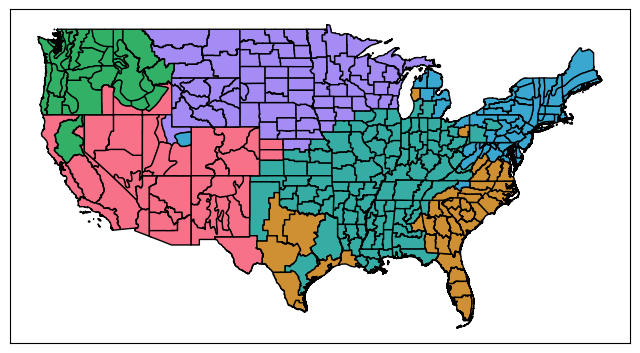

In [16]:
color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(np.array(location_ids)[~outliers]):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        color_label_array[idx[0]] = exkmc_label_array[i]

gdf['color'] = color_label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/climate/imm_map.png', bbox_inches = 'tight', dpi = 300)

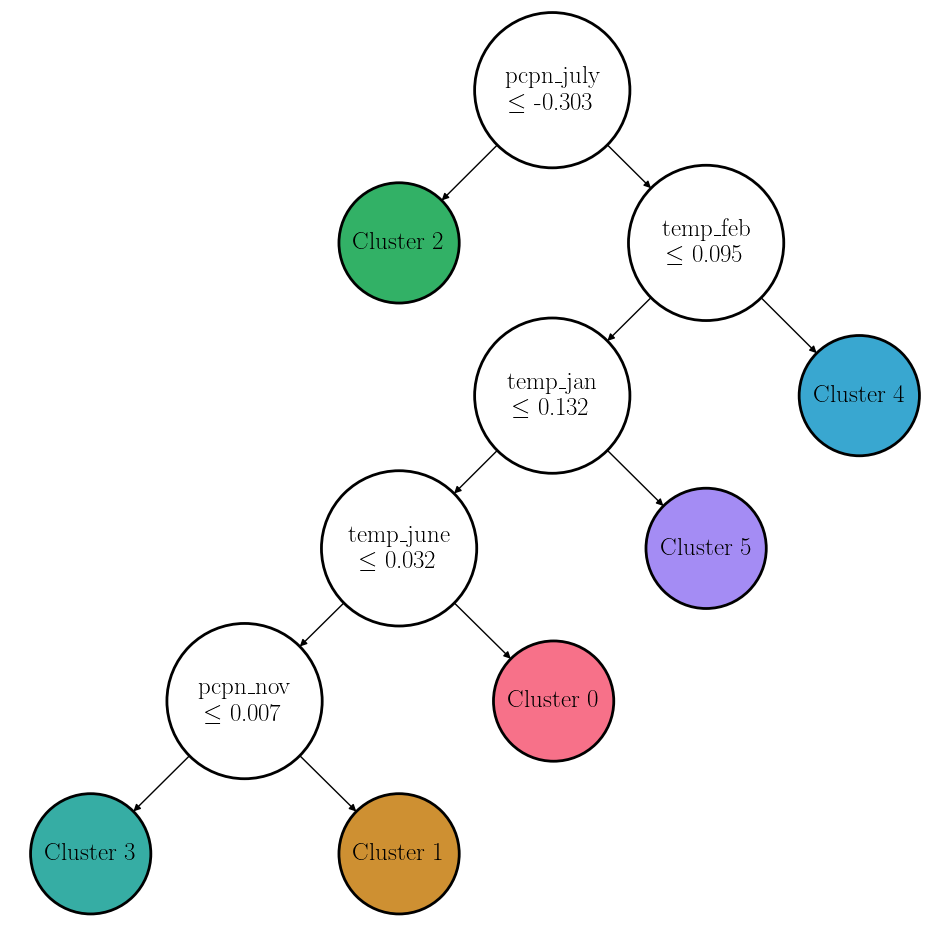

In [77]:
fname = '../figures/climate/imm_tree.png'
#fname = None
'''
cluster_colors = {i: cmap_subset(i) for i in range(k)}
leaf_colors = {i:mcolors.rgb2hex(cmap_subset(i)) for i in range(k)}
visualize_tree(
    root = exkmc_tree.root,
    feature_labels = feature_labels,
    data_scaler = scaler,
    leaf_colors = leaf_colors,
    display_node_info = False,
    output_file = fname
)
'''
draw_tree(
    root = exkmc_tree.root,
    feature_labels = feature_labels,
    data_scaler = scaler,
    cmap = cmap_subset,
    display_node_info = False,
    output_file = fname
)

In [20]:
exkmc_tree.get_weighted_average_depth(data)

3.645348837209302

In [21]:
exkmc_tree.depth

5

## Decision Sets

In [132]:
np.random.seed(342)

In [30]:
# Module Parameters:
k = 6
n_clusters = k
n_rules = k
frac_cover = 0.8
n_trees = 1000
n_sets = 1000
data_labels = kmeans_labels
centers = kmeans.cluster_centers_


# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : 6,
    'max_labels' : 1,
    'max_depths' : [2],
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

# Depth IMM Forest:
forest_tree_params_depth_imm = {
    'max_depth' : 3
}

forest_params_depth_imm = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_imm,
    'num_trees' : 1000,
    'max_features' : 12,
    'max_labels' : 1,
    'max_depths' : [3],
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.9
}


# SVM Set:
svm_params = {
    'num_rules' : n_sets,
    'num_features' : 2,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

In [31]:
# Create and fit the decision set models
forest = DecisionForest(**forest_params_depth_2)
forest.fit(data, kmeans_labels)

forest_depth_imm = DecisionForest(**forest_params_depth_imm)
forest_depth_imm.fit(data, kmeans_labels)

# Oblique takes some time to run!
#oblique_forest = DecisionForest(**oblique_forest_params)
#oblique_forest.fit(data, kmeans_labels)

svm_set = SVMSet(**svm_params)
svm_set.fit(data, kmeans_labels)

### Pruning

#### Tuning $\lambda$

In [32]:
model = forest
search_range = np.linspace(0,5,101)

data_to_rules_assignment = model.get_data_to_rules_assignment(data)
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)
selected_rules, objective_vals, coverage_vals = prune_with_grid_search(
    n_rules = n_rules,
    frac_cover = 0, # Just using 0 required coverage for now to be able to see the full picture.
    n_clusters = n_clusters,
    data_labels = data_labels,
    rule_labels = model.decision_set_labels,
    data_to_rules_assignment = data_to_rules_assignment,
    objective = prune_objective,
    lambda_search_range = search_range,
    cpu_count = 4,
    return_full = True
)

Text(0, 0.5, 'Cost')

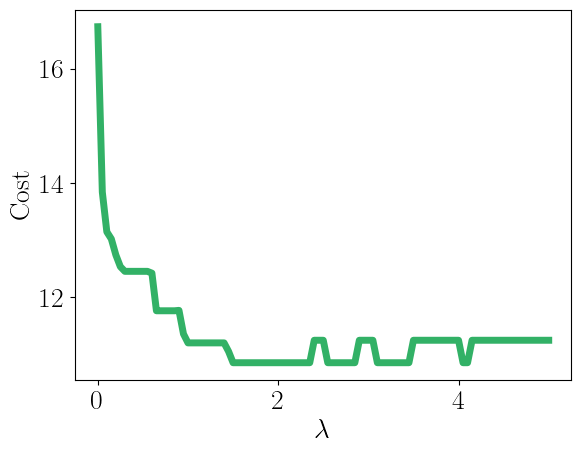

In [24]:
plt.plot(search_range, objective_vals, color = cmap(3), linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Cost")

Text(0, 0.5, 'Coverage')

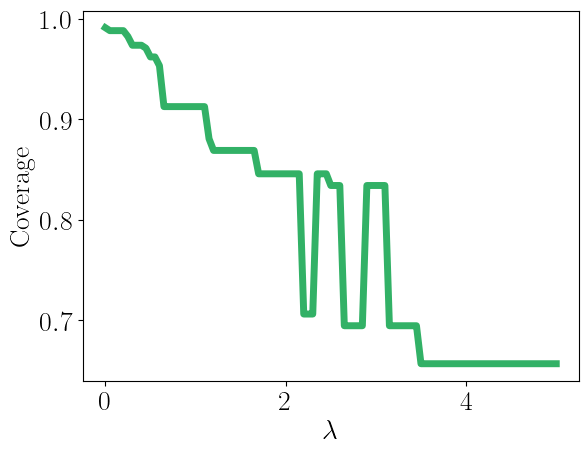

In [33]:
plt.plot(search_range, coverage_vals, color = cmap(3), linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coverage")

#### Selecting Rules

In [34]:
n_rules

6

In [35]:
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)

prune_params = {
    'n_rules' : n_rules,
    'frac_cover' : 0.8,
    'n_clusters' : n_clusters,
    'X' : data,
    'y' : data_labels,
    'objective' : prune_objective,
    'lambda_search_range' : np.linspace(0,5,101),
    'full_search' : False,
    'cpu_count' : 1
}

In [36]:
forest.prune(**prune_params)
if forest.prune_status:
    forest_prune_predictions = forest.pruned_predict(data, rule_labels = False)
else:
    print("Forest pruning failed.")

forest_depth_imm.prune(**prune_params)
if forest_depth_imm.prune_status:
    forest_depth_imm_prune_predictions = forest_depth_imm.pruned_predict(data, rule_labels = False)
else:
    print("Forest depth 5 pruning failed.")

'''
oblique_forest.prune(**prune_params)
if oblique_forest.prune_status:
    oblique_forest_prune_predictions = oblique_forest.pruned_predict(data, rule_labels = False)
else:
    print("Oblique forest pruning failed.")
'''

svm_set.prune(**prune_params)
if svm_set.prune_status:
    svm_set_prune_predictions = svm_set.pruned_predict(data, rule_labels = False)
else:
    print("SVM set pruning failed.")

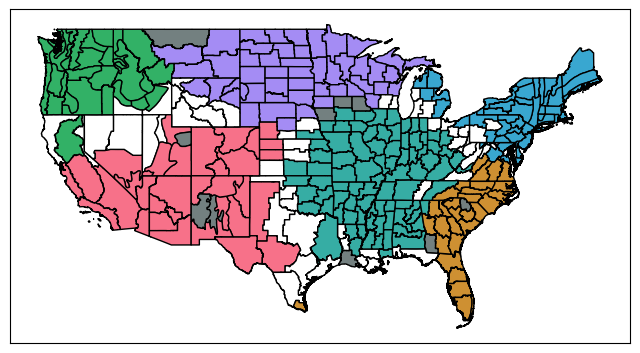

In [41]:
prune_predictions = svm_set_prune_predictions
uncover_colors = subset_colors
if len([l for l in prune_predictions if len(l) > 1]) > 0:
    uncover_colors = [overlap_color] + subset_colors
if len([l for l in prune_predictions if len(l) == 0]) > 0:
    uncover_colors = [uncovered_color] + uncover_colors

cmap_subset_uncover = ListedColormap(uncover_colors)

color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = list(prune_predictions[i])
        if len(l) == 1:
            color_label_array[idx[0]] = l[0]
        elif len(l) > 1:
            color_label_array[idx[0]] = -1
        else:
            color_label_array[idx[0]] = -2

gdf['color'] = color_label_array
fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset_uncover, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
plt.savefig('../figures/climate/svm_map.png', bbox_inches = 'tight', dpi = 300)

In [65]:
pruned_svm = [svm_set.decision_set[i] for i in svm_set.pruned_indices]
pruned_svm[5][0].display(scaler = scaler, feature_labels = feature_labels)

'-5.416$\\cdot$pcpn_apr $+$\n-2.289$\\cdot$pcpn_oct\n$>$ 0.903'

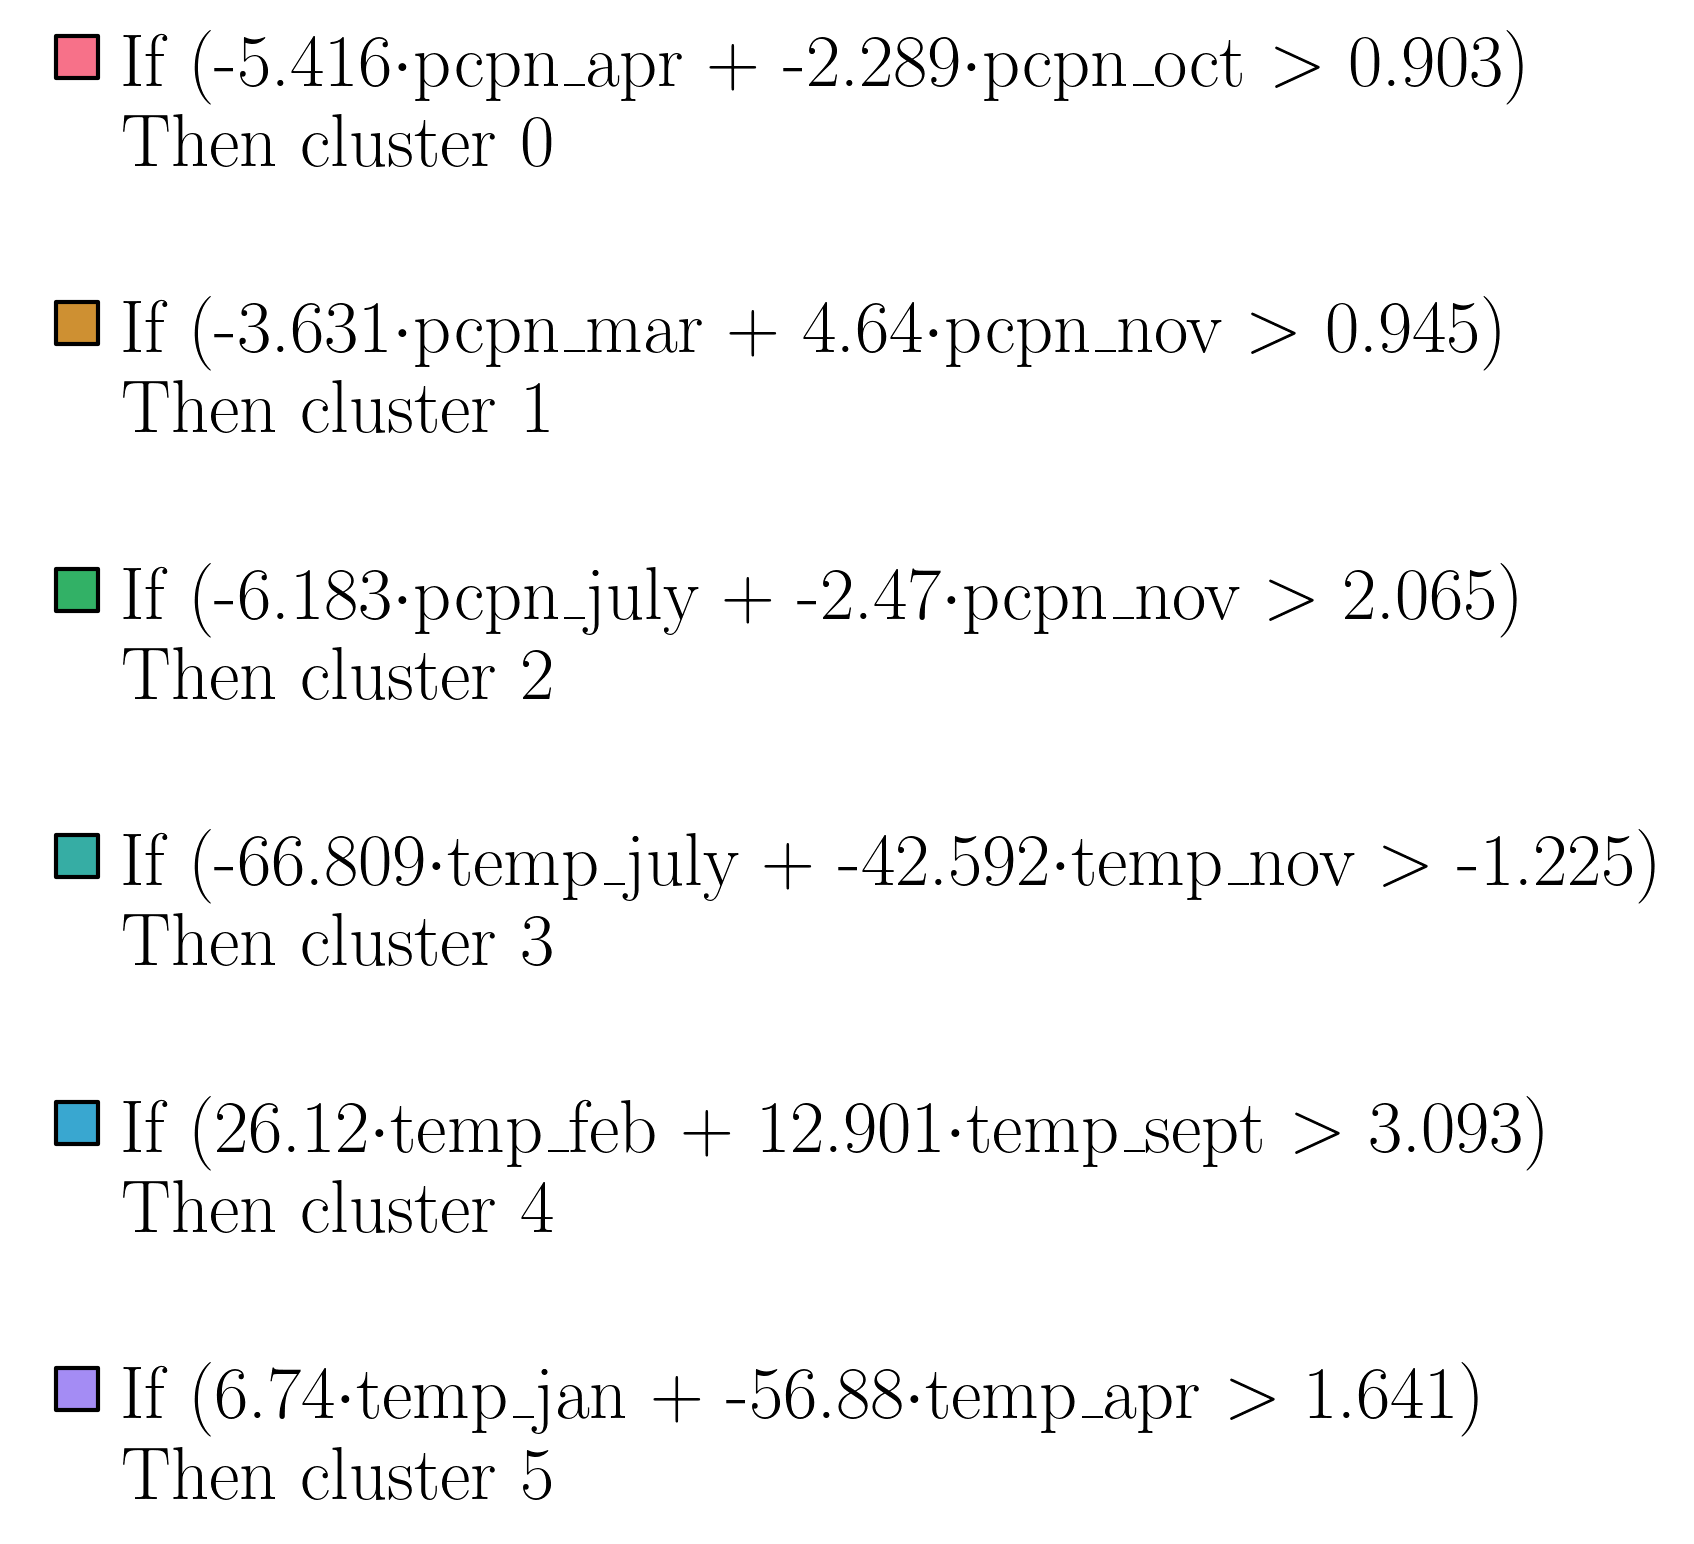

In [69]:
model = svm_set
fname = '../figures/climate/svm_decision_set.png'
#fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    decision_set = [model.decision_set[i] for i in model.pruned_indices],
    rule_labels = [model.decision_set_labels[i] for i in model.pruned_indices],
    feature_labels = feature_labels,
    data_scaler = scaler,
    cmap = cmap_subset,
    filename = fname
)

### Distance Ratio Distributions

In [74]:
prune_predictions = svm_set_prune_predictions
assignment = labels_to_assignment(
    prune_predictions,
    n_labels = n_clusters
)
distance_ratios = distance_ratio(data, centers)

# Single Covers:
single_cover_mask = np.sum(assignment, axis = 1) == 1
single_cover_distance_ratios = distance_ratios[single_cover_mask]

# Overlaps:
overlap_mask = np.sum(assignment, axis = 1) > 1
overlap_distance_ratios = distance_ratios[overlap_mask]

# Uncovereds:
uncovered_mask = np.sum(assignment, axis = 1) < 1
uncovered_distance_ratios = distance_ratios[uncovered_mask]

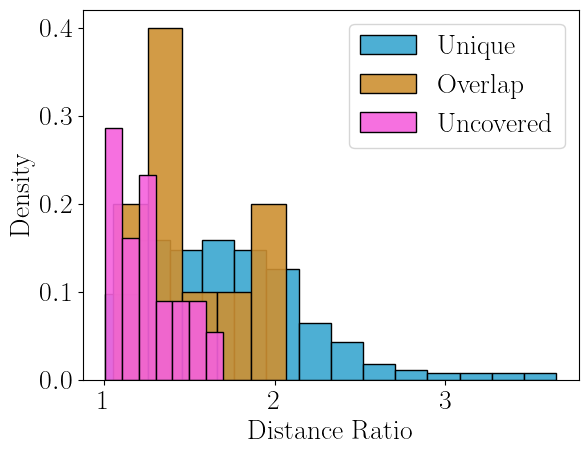

In [75]:
sns.histplot(single_cover_distance_ratios, stat = 'probability', alpha = 0.9, label = "Unique", color = cmap(5))
sns.histplot(overlap_distance_ratios, stat = 'probability', alpha = 0.9, label = "Overlap", color = cmap(1))
sns.histplot(uncovered_distance_ratios, stat = 'probability', alpha = 0.9, label = "Uncovered", color = cmap(7))
plt.ylabel("Density")
plt.xlabel("Distance Ratio")
plt.legend()
plt.savefig('../figures/climate/svm_cover_dist.png', bbox_inches = 'tight', dpi = 300)
